In [109]:
from __future__ import print_function
from random import random
from numpy import array
from numpy import cumsum
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import LSTM, Embedding
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional, Concatenate, concatenate, Dropout, Input, Merge, TimeDistributed, Flatten
from keras.layers import Convolution1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Model
import data_set
from data_set import load_embeddings, fetch_data, fetch_embeddings
from data_set import MAX_SEQUENCE_LENGTH_HEAD
from data_set import MAX_SEQUENCE_LENGTH_BODY
from data_set import EMBEDDING_DIM
from data_set import VALIDATION_SPLIT
from data_set import MAX_NUM_WORDS, embeddings_index, labels_index
import numpy as np
from keras.utils import to_categorical
import pickle
import tensorflow as tf

In [2]:
BASE_DIRECTORY = '/home/harsha/stance-detection'

In [3]:

load_embeddings(BASE_DIR = BASE_DIRECTORY)
(headlines, bodies_map, labels) = fetch_data(BASE_DIR = BASE_DIRECTORY)


Found 400000 word vectors.
All done


In [4]:
(data_head, data_body, embedding_layer_head, embedding_layer_body) = fetch_embeddings(headlines, bodies_map)

Preparing embedding matrix.
All done


In [5]:
pickle.dump((headlines, bodies_map, labels), open("train_file1.txt", "wb"))
pickle.dump((data_head, data_body, embedding_layer_head, embedding_layer_body), open("train_file2.txt", "wb"))

In [6]:
(headlines, bodies_map, _) = pickle.load(open("train_file1.txt", "rb"))
(data_head, data_body, embedding_layer_head, embedding_layer_body) = pickle.load(open("train_file2.txt", "rb"))

In [94]:
#Define model architecture

#Declare Layers
n_classes = 4
emb_size = EMBEDDING_DIM
n_hidden = 48
width = 5

#ConvH
convh_0  = Convolution1D(filters = n_hidden, kernel_size = width, activation='relu', padding='same')
convh_1  = Convolution1D(filters = n_hidden, kernel_size = width, activation='relu', padding='same')
convh_2  = Convolution1D(filters = 2*n_hidden, kernel_size = width, activation='relu', padding='same')
convh_3  = Convolution1D(filters = 2*n_hidden, kernel_size = width, activation='relu', padding='same')
convh_4  = Convolution1D(filters = 3*n_hidden, kernel_size = width, activation='relu', padding='same')

#ConvB
convb_0  = Convolution1D(filters = n_hidden, kernel_size = width, activation='relu', padding='same')
convb_1  = Convolution1D(filters = n_hidden, kernel_size = width, activation='relu', padding='same')
convb_2  = Convolution1D(filters = 2*n_hidden, kernel_size = width, activation='relu', padding='same')
convb_3  = Convolution1D(filters = 2*n_hidden, kernel_size = width, activation='relu', padding='same')
convb_4  = Convolution1D(filters = 3*n_hidden, kernel_size = width, activation='relu', padding='same')

#Dense
dense_0 = Dense(n_hidden*4, activation='relu')
dense_1 = Dense(n_hidden*4, activation='relu')
dense_2 = Dense(n_hidden*2, activation='relu')
dense_f = Dense(n_classes, activation='softmax', name='out')

#Dropout
dperc = 0.5

#DropH
droph_0 = Dropout(dperc)
droph_1 = Dropout(dperc)
droph_2 = Dropout(dperc)
droph_3 = Dropout(dperc)
droph_4 = Dropout(dperc)

#DropB
dropb_0 = Dropout(dperc)
dropb_1 = Dropout(dperc)
dropb_2 = Dropout(dperc)
dropb_3 = Dropout(dperc)
dropb_4 = Dropout(dperc)

#PoolingH
poolh_0 = MaxPooling1D(pool_size=3, padding='same')
poolh_1 = MaxPooling1D(pool_size=3, padding='same')
poolh_2 = MaxPooling1D(pool_size=3, padding='same')

#PoolingB
poolb_0 = MaxPooling1D(pool_size=3, padding='same')
poolb_1 = MaxPooling1D(pool_size=3, padding='same')
poolb_2 = MaxPooling1D(pool_size=3, padding='same')

#Input formats
input_title   = Input(shape=(MAX_SEQUENCE_LENGTH_HEAD, ), dtype='int32', name='input_title')
input_body   = Input(shape=(MAX_SEQUENCE_LENGTH_BODY, ), dtype='int32', name='input_body')

#Create Layers - Title
x = input_title
x = embedding_layer_head(x)
x = convh_0(x)
x = droph_0(x)
x = poolh_0(x)
#x = convh_1(x)
#x = droph_1(x)
#x = poolh_1(x)
#x = convh_2(x)
#x = droph_2(x)
#x = poolh_2(x)
x = convh_3(x)
x = droph_3(x)
x = convh_4(x)
x = droph_4(x)

#Create Layers - Body
y = input_body
y = embedding_layer_body(y)
y = convb_0(y)
y = dropb_0(y)
y = poolb_0(y)
#y = convb_1(y)
#y = dropb_1(y)
#y = poolb_1(y)
#y = convb_2(y)
#y = dropb_2(y)
#y = poolb_2(y)
y = convb_3(y)
y = dropb_3(y)
y = convb_4(y)
y = dropb_4(y)

#Max selection
x = GlobalMaxPooling1D()(x)
y = GlobalMaxPooling1D()(y)

#Concatenate Layers
z = concatenate([x, y])
#z = Merge(mode="concat",name="concat_layer")([x_new, y_new])

#Create Dense layers
z = dense_0(z)
#z = dense_1(z)
z = dense_2(z)

#Output layer
out = dense_f(z)

#Summary
model = Model(inputs=[input_title, input_body], outputs=[out])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_title (InputLayer)        (None, 50)           0                                            
__________________________________________________________________________________________________
input_body (InputLayer)         (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 50)       194000      input_title[0][0]                
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 50)      1000000     input_body[0][0]                 
__________________________________________________________________________________________________
conv1d_106

In [73]:
from keras.utils import plot_model
import pydot_ng as pydot
plot_model(model, to_file='model.png')

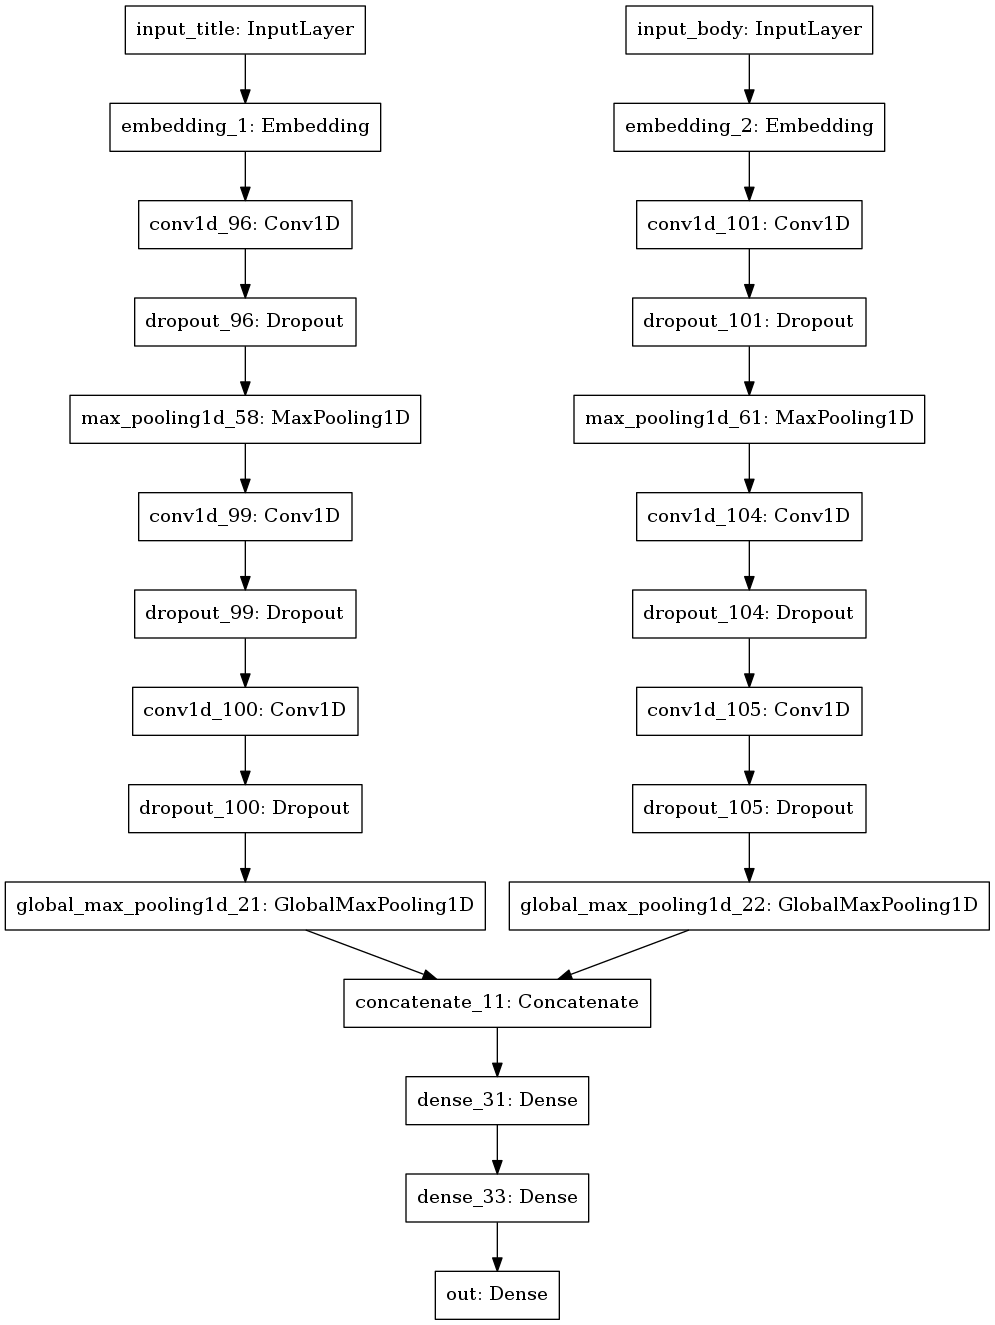

In [74]:
from IPython.display import Image
Image(filename='model.png') 

In [113]:
import keras.backend as K
def w_categorical_crossentropy(y_true, y_pred):
    print(y_true, y_pred)
    p0 = tf.map_fn(lambda x:x[0], y_pred, dtype=tf.float32)
    import math
    loss = -tf.log(p0)
    param = 1
    sumP = y_pred[:,1] + y_pred[:,2] + y_pred[:,3]
    for i in range(1,4):
        loss += (-(y_true[:,i]*tf.log(1-p0)) - param*(y_true[:,i]*tf.log(y_pred[:,i]/())))
    return loss

In [114]:
#Compile
optimizer = Adam(lr=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-08) # Optimization hyperparameters.
# from functools import partial
model.compile(optimizer=optimizer,
              loss = w_categorical_crossentropy,
#               loss_weights={'out': 1.0}, # These can be tuned.
              metrics=['accuracy'])
#lr=0.0002, b1=0.1, b2=0.001, e=1e-8

Tensor("out_target_28:0", shape=(?, ?), dtype=float32) Tensor("out_11/Softmax:0", shape=(?, 4), dtype=float32)


In [125]:
# ORIGINAL

optimizer = Adam(lr=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-08) # Optimization hyperparameters.

model.compile(optimizer=optimizer,
              loss={'out':'categorical_crossentropy'},
              loss_weights={'out': 1.0}, # These can be tuned.
              metrics=['accuracy'])

In [126]:
#Train and Validate
labels = to_categorical(np.asarray(list(zip(*headlines))[2]))
#class_weight = { 0: 10., 1: 1., 2: 1., 3: 2.}
model.fit([data_head, data_body], labels, batch_size=12, epochs=10)#, class_weight = class_weight)

Epoch 1/10
49972/49972 [==============================] - 42s 836us/step - loss: 0.7317 - acc: 0.7344
Epoch 2/10
49972/49972 [==============================] - 40s 802us/step - loss: 0.5867 - acc: 0.7660
Epoch 3/10
49972/49972 [==============================] - 40s 799us/step - loss: 0.5296 - acc: 0.7879
Epoch 4/10
49972/49972 [==============================] - 40s 810us/step - loss: 0.4937 - acc: 0.8037
Epoch 5/10
49972/49972 [==============================] - 42s 840us/step - loss: 0.4697 - acc: 0.8142
Epoch 6/10
49972/49972 [==============================] - 95s 2ms/step - loss: 0.4496 - acc: 0.8204
Epoch 7/10
49972/49972 [==============================] - 95s 2ms/step - loss: 0.4362 - acc: 0.8270
Epoch 8/10
49972/49972 [==============================] - 94s 2ms/step - loss: 0.4288 - acc: 0.8302
Epoch 9/10
49972/49972 [==============================] - 93s 2ms/step - loss: 0.4190 - acc: 0.8350
Epoch 10/10
49972/49972 [==============================] - 84s 2ms/step - loss: 0.4138 - a

In [128]:
#Confusion matrix - Train
train_y_pred = model.predict([data_head, data_body])
train_labels = to_categorical(np.asarray(list(zip(*headlines))[2]))
train_lab = np.argmax(train_labels, axis = 1)
train_pred = np.argmax(train_y_pred, axis = 1)
from sklearn.metrics import confusion_matrix
confusion_matrix(train_lab, train_pred)

array([[30672,  2812,     0,  3061],
       [   89,  2823,     0,   766],
       [   21,   519,     0,   300],
       [  228,  1212,     0,  7469]])

In [52]:
train_y_pred

array([[9.11714315e-01, 1.65717937e-02, 1.05153501e-03, 7.06623346e-02],
       [7.58208752e-01, 5.77269383e-02, 1.12333484e-02, 1.72830939e-01],
       [9.98502851e-01, 8.88144205e-05, 8.77892816e-08, 1.40822795e-03],
       ...,
       [6.11970067e-01, 1.01347655e-01, 3.62224430e-02, 2.50459790e-01],
       [6.94301665e-01, 7.65733346e-02, 1.99120883e-02, 2.09212944e-01],
       [9.91910160e-01, 7.90554564e-04, 4.34440472e-06, 7.29487650e-03]],
      dtype=float32)

In [12]:
(test_headlines, test_bodies_map, test_labels) = fetch_data(mode = 'test', BASE_DIR = BASE_DIRECTORY)
(test_data_head, test_data_body, test_embedding_layer_head, test_embedding_layer_body) = fetch_embeddings(test_headlines, test_bodies_map)

All done
Preparing embedding matrix.
All done


In [13]:
pickle.dump((test_headlines, test_bodies_map, test_labels), open("test_file1.txt", "wb"))
pickle.dump((test_data_head, test_data_body, test_embedding_layer_head, test_embedding_layer_body), open("test_file2.txt", "wb"))

In [129]:
(test_headlines, test_bodies_map, _) = pickle.load(open("test_file1.txt", "rb"))
(test_data_head, test_data_body, test_embedding_layer_head, test_embedding_layer_body) = pickle.load(open("test_file2.txt", "rb"))

In [130]:
#Confusion matrix - Test
test_y_pred = model.predict([test_data_head, test_data_body])
test_labels = to_categorical(np.asarray(list(zip(*test_headlines))[2]))
test_lab = np.argmax(test_labels, axis = 1)
pred = np.argmax(test_y_pred, axis = 1)
from sklearn.metrics import confusion_matrix
confusion_matrix(test_lab, pred)

array([[7643, 3855,    0, 6851],
       [ 815,  391,    0,  697],
       [ 348,  120,    0,  229],
       [1702, 1023,    0, 1739]])

In [16]:
model.save_weights('32b_10e.txt')

In [17]:
import h5py

In [120]:
test_lab[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 3, 1, 0, 0, 0, 0, 3, 1,
       1, 2, 3, 0, 0, 3, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 3, 0, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0,
       0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [121]:
pred[:100]

array([3, 0, 1, 3, 0, 1, 0, 1, 3, 0, 1, 0, 0, 0, 1, 3, 1, 3, 0, 0, 0, 1,
       3, 0, 1, 3, 0, 3, 0, 1, 3, 0, 3, 0, 3, 0, 0, 1, 3, 1, 1, 3, 0, 3,
       0, 3, 0, 0, 3, 0, 1, 1, 3, 0, 1, 3, 0, 1, 3, 0, 0, 0, 1, 3, 3, 3,
       1, 1, 0, 1, 0, 3, 1, 1, 3, 0, 0, 3, 1, 1, 0, 0, 0, 0, 1, 0, 3, 3,
       1, 1, 3, 0, 3, 1, 1, 3, 3, 3, 0, 1])

In [123]:
print(test_lab==pred)

[ True  True  True ...  True  True  True]


In [131]:
def fnc_score(C):
    score = 0
    score += C[0][0]*0.25
    score += 0.25*(sum(sum(C[1:, 1:])))
    score += 0.75*(C[1][1] + C[2][2] + C[3][3])
    return score

In [132]:
fnc_score(array([[7643, 3855,    0, 6851],
       [ 815,  391,    0,  697],
       [ 348,  120,    0,  229],
       [1702, 1023,    0, 1739]]))

4558.0